In [1]:
import json
import os
import warnings
from pathlib import Path

import pandas as pd
import plotly.express as px
import plotly.io as pio

# Dica: pathlib é mais robusto que os.path para manipulação de arquivos

In [2]:
# --- Configurações do Pandas ---
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# --- Configurações de Avisos ---
warnings.filterwarnings('ignore')

# --- Configurações do Plotly ---
pio.templates.default = "plotly_white"
# Configuração de fonte global para gráficos
pio.templates[pio.templates.default].layout.font = dict(
    family="Arial, sans-serif",
    size=16,
    color="black"
)

# --- Definição de Caminhos e Diretórios ---
# Ajuste os nomes dos arquivos conforme necessário
DATASET_PATH = Path('lorawan_antwerp_2019_dataset.json')
GATEWAYS_PATH = Path('lorawan_antwerp_gateway_locations.json')
OUTPUT_DIR = Path("imagens/")

# Garante a criação do diretório de saída
if not OUTPUT_DIR.exists():
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    print(f"Diretório '{OUTPUT_DIR}' criado.")
else:
    print(f"Diretório de saída configurado: {OUTPUT_DIR}")

Diretório de saída configurado: imagens


In [3]:
def carregar_dados(dataset_path, gateways_path):
    """
    Carrega os datasets JSON e retorna DataFrames pandas.
    """
    try:
        if not dataset_path.exists() or not gateways_path.exists():
            raise FileNotFoundError("Arquivos JSON não encontrados no diretório.")

        with open(dataset_path, 'r') as f:
            data = json.load(f)
        df_main = pd.DataFrame(data)

        with open(gateways_path, 'r') as f:
            gw_locs = json.load(f)
        df_gw = pd.DataFrame.from_dict(gw_locs, orient='index')

        print(f"Dados carregados com sucesso. Registros: {len(df_main)}")
        return df_main, df_gw

    except Exception as e:
        print(f"Erro crítico ao carregar dados: {e}")
        return None, None

def salvar_e_exibir(fig, nome_arquivo, titulo_exibicao):
    """
    Salva a figura em PNG de alta qualidade sem título e exibe com título no notebook.
    
    Args:
        fig: Objeto figura do Plotly.
        nome_arquivo: Nome do arquivo (ex: 'grafico.png').
        titulo_exibicao: Título para mostrar no notebook (fig.show).
    """
    # 1. Configuração para salvar (Sem título)
    fig.update_layout(title_text=None)
    
    caminho_completo = OUTPUT_DIR / nome_arquivo
    # Scale=3 gera uma imagem 3x maior (aprox 300 DPI), ideal para artigos/impressão
    fig.write_image(caminho_completo, scale=3)
    print(f"Imagem salva: {caminho_completo}")
    
    # 2. Configuração para exibir (Com título)
    fig.update_layout(title_text=titulo_exibicao)
    fig.show()

# Execução do Carregamento
df, gateways_df = carregar_dados(DATASET_PATH, GATEWAYS_PATH)
if df is not None:
    display(df.head())

Dados carregados com sucesso. Registros: 130430


adr  hdop  counter  longitude  sf   airtime  dev_addr                                           gateways   latitude           dev_eui                                            payload  channel
0    1  0.66   100086   4.427051   7  0.112896  07000EFF  [{'id': '080605EE', 'rssi': -104, 'snr': -3.25...  51.235508  343233386A377C18  00eb000329f14c4267aa8d40c3f5283f0400ca55410510...        6
1    1  0.83    62377   4.397273   7  0.112896  07000EAD  [{'id': '08060716', 'rssi': -99, 'snr': 10.0, ...  51.203171  3432333855378A18  003900030cd04c4276b68c40e17a543f048051bf4105c0...        8
2    1  0.70    31952   4.400576   7  0.112896  07000EFE  [{'id': '08060716', 'rssi': -115, 'snr': 6.75,...  51.208565  3432333853376B18  008d000392d54c4284d18c403333333f04682aa9410500...        8
3    1  0.64    57377   4.391779   7  0.112896  07000FB2  [{'id': 'FF0178DF', 'rssi': -85, 'snr': -5.0, ...  51.202320  3432333864377C18  00c300032dcf4c4275898c400bd7233f0430896b410540...        3
4    1  0.64   112480   4.417615   8  0.205312  07000ECB  [{'id': 'FF0107C9', 'rssi': -114, 'snr': -4.0,...  51.211182  3432333855376418  00f6000340d84c421a5d8d400bd7233f040832bb4105a0...        7

Imagem salva: imagens/distribuicao_rssi.png


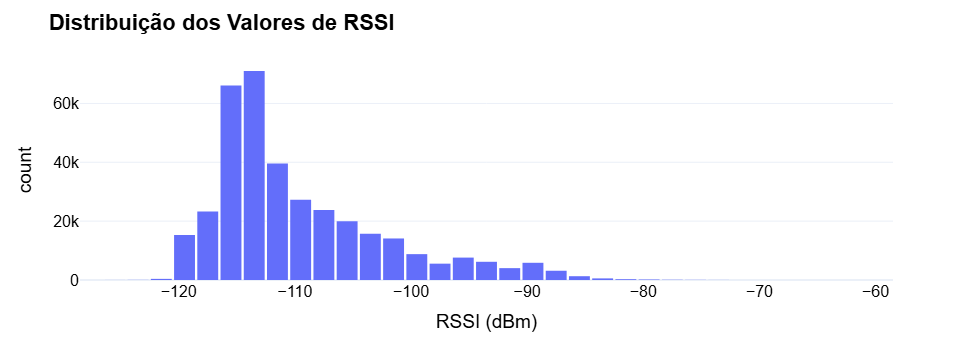

Imagem salva: imagens/distribuicao_snr.png


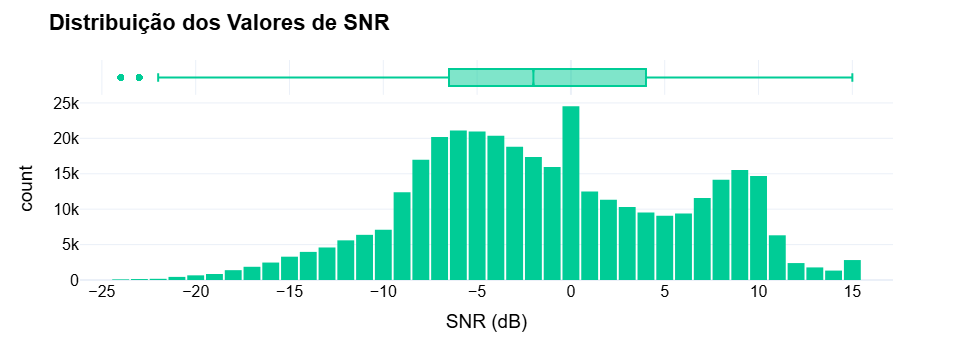

In [9]:
if df is not None:
    # Processamento: Extração eficiente usando List Comprehension
    # Explanando a estrutura aninhada de gateways
    all_rssi = [gw['rssi'] for record in df['gateways'] for gw in record]
    all_snr = [gw['snr'] for record in df['gateways'] for gw in record]

    # Criação de DataFrames temporários para plotagem
    df_rssi = pd.DataFrame(all_rssi, columns=['RSSI (dBm)'])
    df_snr = pd.DataFrame(all_snr, columns=['SNR (dB)'])

    # --- Gráfico 1: RSSI ---
    fig_rssi = px.histogram(
        df_rssi, 
        x='RSSI (dBm)', 
        nbins=50,
        color_discrete_sequence=['#636EFA'] # Azul Plotly padrão
    )
    fig_rssi.update_layout(bargap=0.1)
    salvar_e_exibir(fig_rssi, "distribuicao_rssi.png", "<b>Distribuição dos Valores de RSSI</b>")

    # --- Gráfico 2: SNR ---
    fig_snr = px.histogram(
        df_snr, 
        x='SNR (dB)', 
        marginal="box", 
        nbins=50, 
        color_discrete_sequence=['#00CC96'] # Verde
    )
    fig_snr.update_layout(bargap=0.1)
    salvar_e_exibir(fig_snr, "distribuicao_snr.png", "<b>Distribuição dos Valores de SNR</b>")

In [5]:
if df is not None:
    # Engenharia de Features
    df['num_gateways'] = df['gateways'].apply(len)
    
    # Agregação
    gw_counts = df['num_gateways'].value_counts().sort_index().reset_index()
    gw_counts.columns = ['num_gateways', 'contagem']

    # --- Gráfico 3: Cobertura ---
    fig_gw = px.bar(
        gw_counts, 
        x='num_gateways', 
        y='contagem',
        labels={'num_gateways': 'Número de Gateways', 'contagem': 'Transmissões'},
        text_auto=True # Adiciona valores nas barras automaticamente
    )
    
    # Forçar eixo X como categoria (evita 1.5, 2.5)
    fig_gw.update_xaxes(type='category')
    
    salvar_e_exibir(fig_gw, "contagem_gateways.png", "<b>Cobertura: Gateways por Transmissão</b>")

    # Estatística textual
    min_gw = 3
    pct_viavel = (df['num_gateways'] >= min_gw).mean() * 100
    print(f"\nInsight: {pct_viavel:.2f}% dos pacotes foram recebidos por {min_gw} ou mais gateways.")

Imagem salva: imagens/contagem_gateways.png



Insight: 42.46% dos pacotes foram recebidos por 3 ou mais gateways.


Imagem salva: imagens/distribuicao_sf.png


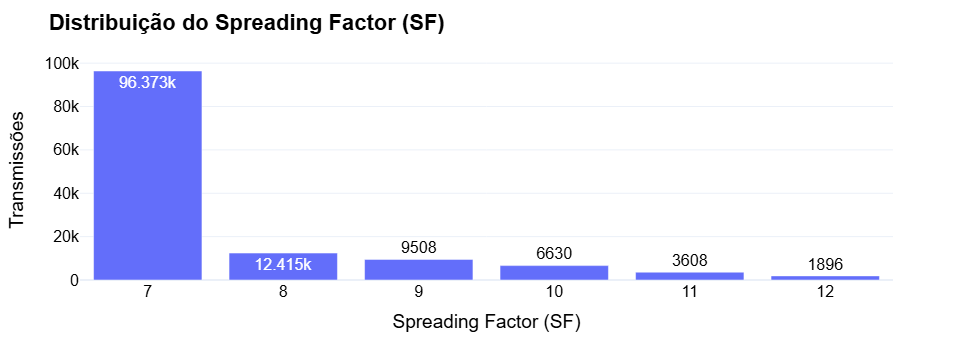

In [7]:
if df is not None:
    # Agregação
    sf_counts = df['sf'].value_counts().sort_index().reset_index()
    sf_counts.columns = ['sf', 'contagem']
    # Garantir que SF seja tratado como string/categoria no gráfico
    sf_counts['sf'] = sf_counts['sf'].astype(str)

    # --- Gráfico 4: Spreading Factor ---
    fig_sf = px.bar(
        sf_counts, 
        x='sf', 
        y='contagem',
        labels={'sf': 'Spreading Factor (SF)', 'contagem': 'Transmissões'},
        text_auto=True
    )
    
    salvar_e_exibir(fig_sf, "distribuicao_sf.png", "<b>Distribuição do Spreading Factor (SF)</b>")